### data load
- 데이터를 불러와 살펴보고 주요 통계치들을 살펴봅니다
- 이번 자료에서는 click 데이터에 있는 session id, timestamp, itemld 칼럼만 사용합니다

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data') 
train_path = data_path / 'yoochoose-clicks.dat'
train_path

PosixPath('/aiffel/aiffel/yoochoose/data/yoochoose-clicks.dat')

In [3]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep=',', header=None, usecols=[0, 1, 2],
                       parse_dates=[1], dtype={0: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['SessionId', 'Time', 'ItemId']
    return data

In [4]:
# 시간이 좀 걸릴 수 있습니다. 메모리도 10GB 가까이 소요될 수 있으니 메모리 상태에 주의해 주세요.  

data = load_data(train_path, None)
data.sort_values(['SessionId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,SessionId,Time,ItemId
0,1,2014-04-07 10:51:09.277000+00:00,214536502
1,1,2014-04-07 10:54:09.868000+00:00,214536500
2,1,2014-04-07 10:54:46.998000+00:00,214536506
3,1,2014-04-07 10:57:00.306000+00:00,214577561
4,2,2014-04-07 13:56:37.614000+00:00,214662742
...,...,...,...
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774
32230489,11562158,2014-09-26 05:16:32.904000+00:00,214849132
32230490,11562159,2014-09-26 19:16:28.897000+00:00,214849132


In [5]:
# 먼저 세션수(유저수)와 아이템 수를 확인
data['SessionId'].nunique(), data['ItemId'].nunique()

(9249729, 52739)

결과로 (9249729, 52739)가 나왔다. 세션의 숫자가 약 900만개, 아이템 숫자는 약 5만개. 이 수치가 유저의 수가 900만명이라는 것을 의미하지는 않는데, 그 이유는 한 유저가 여러 개의 세션을 만들수도 있기 때문입니다.

### session length
각 세션이 대략 몇 개의 클릭 데이터를 갖는지 살펴봅니다.

In [6]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
1           4
2           6
3           3
4           2
6           2
           ..
11562156    2
11562157    2
11562158    3
11562159    1
11562161    1
Length: 9249729, dtype: int64

여기서 session_length란 같은 sessionid를 공유하는 데이터 row의 개수를 의미. 여기서 sessionid란 브라우저에서 웹서버로 접속할 때 항상 포함하게 되는 유저 구분자 입니다. 로그인하지 않았기 때문에 이 사용자가 누군지는 알 수 없어도, 최소한 특정 사용자의 행동을 sessionid기준으로 모아서 분류가 가능. 즉, session_length란 해당 세션의 사용자가 그 세션 동안 몇번의 액션을 취했는지(몇개의 상품정보를 클릭했는지)의 의미가 됨.

In [8]:
print('중간, 평군: ',session_length.median(), session_length.mean())
print('최소, 최대: ',session_length.min(), session_length.max())
print('99.9%: ',session_length.quantile(0.999))

중간, 평군:  2.0 3.568098481587947
최소, 최대:  1 200
99.9%:  41.0


- 각 세션의 길이는 보통 2~3정도.
- 99.9% 세션은 길이가 41이하.
- 길이가 200인 세션은 뭔가 이상.

In [19]:
long_session = session_length[session_length==200].index[0] # sessionid중 200 이상인것 중에 가장 첫번째, 189448을 확인
data[data['SessionId']==long_session]

,SessionId,Time,ItemId
580293,189448,2014-04-01 08:56:28.983000+00:00,214830392
580294,189448,2014-04-01 08:56:31.815000+00:00,214830392
580295,189448,2014-04-01 08:57:08.301000+00:00,214830392
580296,189448,2014-04-01 08:57:10.338000+00:00,214830392
580297,189448,2014-04-01 08:58:01.728000+00:00,214830390
...,...,...,...
580488,189448,2014-04-01 10:35:52.400000+00:00,214830137
580489,189448,2014-04-01 10:37:15.094000+00:00,214830118
580490,189448,2014-04-01 10:37:35.955000+00:00,214830118
580491,189448,2014-04-01 10:37:37.098000+00:00,214830118


매우 짧은 간격으로 지속적으로 클릭을 1시간 30분 가량 지속하고 있습니다. 유저들의 서비스 이용행태는 다양하기 때문에 데이터 전처리를 어떻게 할지는 모델을 만드는 사람이 판단. 너무 긴 세션을 제거할 수도 있고 포함할 수도 있다.이러한 판단을 위해서 시각화를 해보겠습니다. 아래는 세션길이 기준 하위 99.9%까지의 분포 누적합을 시각화 한것.

In [20]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1     0.136189
2     0.520858
3     0.695280
4     0.796461
5     0.855125
6     0.894389
7     0.920036
8     0.938321
9     0.951293
10    0.961084
11    0.968267
12    0.973959
13    0.978320
14    0.981815
15    0.984587
16    0.986837
17    0.988673
18    0.990201
19    0.991460
20    0.992520
21    0.993436
22    0.994207
23    0.994871
24    0.995444
25    0.995920
26    0.996342
27    0.996714
28    0.997042
29    0.997330
30    0.997577
31    0.997796
32    0.998001
33    0.998177
34    0.998327
35    0.998461
36    0.998590
37    0.998706
38    0.998805
39    0.998896
40    0.998981
dtype: float64

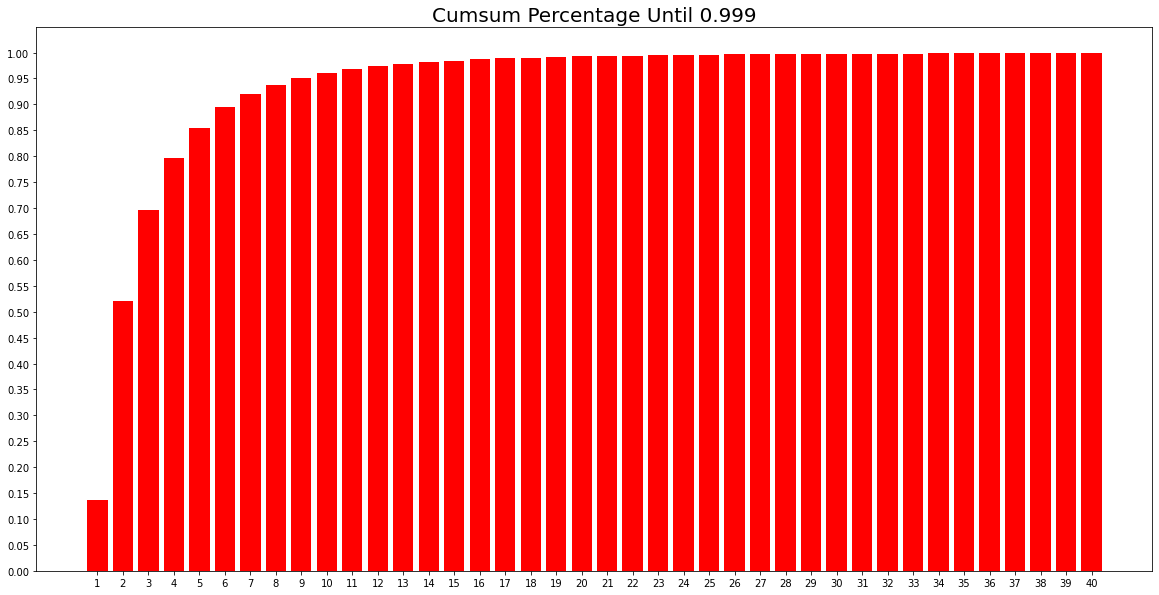

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### session time
추천시스템을 구축할 때에는 최근 소비 트렌드를 학습하는 것이 중요합니다. 따라서 우리가 다루려는 데이터의 시간 관련 정보를 확인해 봅시다.

In [22]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2014-04-01 03:00:00.124000+00:00
2014-09-30 02:59:59.430000+00:00


데이터 설명대로 6개월치 데이터가 있습니다. 우리는 1달치 데이터만 사용합니다. 만약 6개월치 데이터를 사용하면 성능이 더 좋아질까요?

In [23]:
# latest는 timestamp 객체이기 때문에 int 객체와의 사칙연산을 지원하지 않습니다.
# 날짜끼리의 차이를 구하고 싶을때는 datetime 라이브러리의 timedelta 객체를 사용합니다.
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [24]:
month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,SessionId,Time,ItemId
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420
26838214,9194112,2014-09-01 13:26:36.292000+00:00,214853422
...,...,...,...
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774
32230489,11562158,2014-09-26 05:16:32.904000+00:00,214849132
32230490,11562159,2014-09-26 19:16:28.897000+00:00,214849132


### data cleansing
길이가 1인 세션도 있었습니다. 우리의 목적은 유저가 최소 1개 이상 클릭했을때 다음 클릭을 예측하는 것이므로 길이가 1인 세션은 제거해줍니다. 너무 적게 클릭된 아이템은 이상한 아이템일 가능성이 있습니다. 이 역시 제거해줍니다.

In [26]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [27]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,SessionId,Time,ItemId
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207
...,...,...,...
32230485,11562157,2014-09-25 12:31:10.391000+00:00,214580372
32230486,11562157,2014-09-25 12:31:29.679000+00:00,214516012
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774


### train/valid/test split
모델평가를 위해 valid set과 test set을 만듭니다. 대회에서 test set을 제공해주고 있습니다.

In [28]:
test_path = data_path / 'yoochoose-test.dat'
test= load_data(test_path)
test['Time'].min(), test['Time'].max()

(Timestamp('2014-04-01 03:00:08.250000+0000', tz='UTC'),
 Timestamp('2014-09-30 02:59:23.866000+0000', tz='UTC'))

- test셋을 살펴보면 training셋과 기간이 겹치는데, 위에서 언급하듯 추천 시스템은 '지금' 잘 예측하는게 중요해서, 1달 전에 성능이 좋았던 모델을 지금 사용하면 사용자들의 소비 패턴이 달라져 성능이 잘 나오지 않을수 있습니다. 이러한 이유로 session-based recommendation에서는 기간에 따라 train/valid/test셋을 나누기도 합니다.


- 우리는 가장 마지막 1일 기간 동안을 test로, 2일전부터 1일 전까지를 valid set으로 나누겠습니다. 이 외의 기간은 training입니다. 즉, 1일부터 28일 까지는 training, 29일은 valid, 30일은 test셋 으로 나눠진다고 볼 수 있습니다.

In [29]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [30]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [31]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [32]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 5125100
	 Sessions: 1243431
	 Items: 20153
	 First Time : 2014-08-31 03:00:01.111000+00:00
	 Last Time : 2014-09-28 02:57:34.348000+00:00

* valid Set Stats Info
	 Events: 58074
	 Sessions: 12350
	 Items: 6232
	 First Time : 2014-09-28 03:00:25.298000+00:00
	 Last Time : 2014-09-29 02:58:27.660000+00:00

* test Set Stats Info
	 Events: 71009
	 Sessions: 15289
	 Items: 6580
	 First Time : 2014-09-29 02:37:20.695000+00:00
	 Last Time : 2014-09-30 02:59:59.430000+00:00



In [33]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [34]:
# 데이터 준비를 마쳤습니다. 데이터를 저장한 다음 data pipeline을 구축하는 단계로 넘어갑니다.
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# 논문소개
이번 자료에서 사용할 모델은 2016년 ICLR에 공개된 session-based recommendations with recurrent nerual networks 입니다. session data에서는 처음으로 RNN 계열 모델을 적용하여 발표했습니다.

여러 RNN 계열의 모델(e.g. LSTM)이 있겠지만 저자가 실험해본 결과 GRU의 성능이 제일 좋았다고 합니다.
또한 Embedding Layer를 사용하지 않았을 때가 사용했을 때보다 성능이 좋았다고 합니다.
이번 자료에서도 Embedding Layer를 사용하지 않고 One-hot Encoding만 사용하겠습니다.

대신 추천 데이터의 특징 몇 가지를 살려 모델링을 했습니다.

- Session-Parallel Mini-Batches : 위에서 보았듯이 Session의 길이는 매우 짧은 것들이 대부분입니다. 그러나 매우 긴 것들도 있습니다.이 세션들을 데이터 샘플 하나로 보고 mini-batch를 구성하여 input으로 넣는다면 길이가 제일 긴 세션의 연산이 끝날 때까지 짧은 세션들이 기다려야 합니다.

- SAMPLING ON THE OUTPUT : Negative Sampling와 같은 개념입니다. Item의 수가 많기 때문에 Loss를 계산할 때 모든 아이템을 비교하지 않고 인기도를 고려하여 Sampling합니다. 이번 자료에서는 구현하지 않았습니다.

- Ranking Loss: Session-Based Recommendation Task를 여러 아이템 중 다음 아이템이 무엇인지 Classification하는 Task로 생각할 수도 있습니다.그러나 여러 아이템을 관련도 순으로 랭킹을 매겨서 높은 랭킹의 아이템을 추천하는 Task로도 생각할 수 있습니다. 추천 시스템 연구 분야에서는 이렇게 Ranking을 맞추는 objective function에 대한 연구가 있었고 논문의 저자 역시 이런 Loss를 사용했습니다. 그러나 이번 자료에서는 Classification Task로 보고 Cross-Entropy Loss를 사용하겠습니다.

### data pipeline: sessiondataset
이전 스텝에서 개념을 정리해 본 session parallel mini batch를 구현합니다


In [35]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

train데이터로 sessiondataset 객체를 만들고 인스턴스 변수들을 살펴보겠습니다. click_offsets변수는 각 세션이 시작된 인덱스를 담고 있습니다. session_idx 변수는 각 세션을 인덱싱한 np.array입니다.

In [36]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,Time,ItemId,item_idx
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
26838203,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
26838193,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
26838194,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
26838196,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
26838197,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [37]:
tr_dataset.click_offsets

array([      0,       4,       6, ..., 5125095, 5125097, 5125100],
      dtype=int32)

In [38]:
tr_dataset.session_idx

array([      0,       1,       2, ..., 1243428, 1243429, 1243430])

### sessiondataloader
sessiondataset 객체를 받아서 session-parallel mini batch를 만드는 클래스를 만듭니다. `__iter__` 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield합니다. mask는 후에 RNN Cell State를 초기화 하는데 사용할 것 입니다.

In [39]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [40]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,Time,ItemId,item_idx
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
26838203,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
26838193,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
26838194,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
26838196,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
26838197,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [41]:
iter_ex = iter(tr_data_loader)

In [47]:
# 아래 셀을 반복 실행하면 next가 계속 다음 데이터를 만듭니다. 
# input, output, mask의 감을 잡아 봅시다.
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [29 12 23 30]
Label Item Idx are :       [29 13 24 31]
Previous Masked Input Idx are [0 3]


### modeling: evaluation metric
모델 성능 평가를 위한 지표를 보겠습니다. 모델 성능에 대한 지표로 precision 이나 recall이 있습니다. session based recommendation task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋습니다.
이 때문에 recall의 개념을 확장한 recall@k 지표, precision의 개념을 확장한 Mean Average Precision@k 지표 등을 사용합니다.
추천에서는 몇 번째로 맞추느냐도 중요합니다. 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것입니다.
따라서 순서에 민감한 지표인 MRR, NDCG 같은 지표도 사용합니다.
이번 자료에서는 MRR과 Recall@k를 사용하겠습니다. MRR은 정답 아이템이 나온 순번의 역수 값입니다.
따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안나온다면 지표가 낮아질 것입니다.

In [48]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### model architecture
모델 구조가 간단한 편이므로 functional하게 모델을 만듭니다.

In [49]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [50]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [51]:
# 모델에 사용할 hyper-parameter를 class형식으로 관리하겠습니다.
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [52]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 20153)]        0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  3030750   
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 20153)             1027803   
Total params: 4,058,553
Trainable params: 4,058,553
Non-trainable params: 0
_________________________________________________________________


### model training

학습은 총 3 epoch 진행되며, 대략 1시간 정도 소요됩니다. 충분한 epoch은 아니지만, 제대로 작동 하고 있는지 확인할수 있는 수준입니다. 배치 사이즈나 epoch 등의 설정은 위의 args에서 관리하므로 진행전 값을 확인해 주세요.

In [53]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [ ]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

### inference
학습이 완료되었습니다. 지금까지 학습한 모델이 테스트셋에 대해서도 유사한 수준의 성능을 내는지 검증해 봅시다.

In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

# project: Movielens 영화 SBR

### 전처리

In [80]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [81]:
# time의 데이터 형식을 시간으로 바꿔준다.
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [82]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [83]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [84]:
print('중간, 평군: ',user_length.median(), user_length.mean())
print('최소, 최대: ',user_length.min(), user_length.max())
print('99.9%: ',user_length.quantile(0.999))

중간, 평군:  96.0 165.5975165562914
최소, 최대:  20 2314
99.9%:  1343.181000000005


In [85]:
long_session = user_length[user_length==2314].index[0]
data[data['UserId']==long_session].head(20)

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
696168,4169,3801,5,2000-08-03 20:11:21
696250,4169,3841,2,2000-08-03 20:11:21
697903,4169,3761,3,2000-08-03 20:11:21
697954,4169,3788,3,2000-08-03 20:11:21
695653,4169,3794,4,2000-08-03 20:11:59


In [86]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

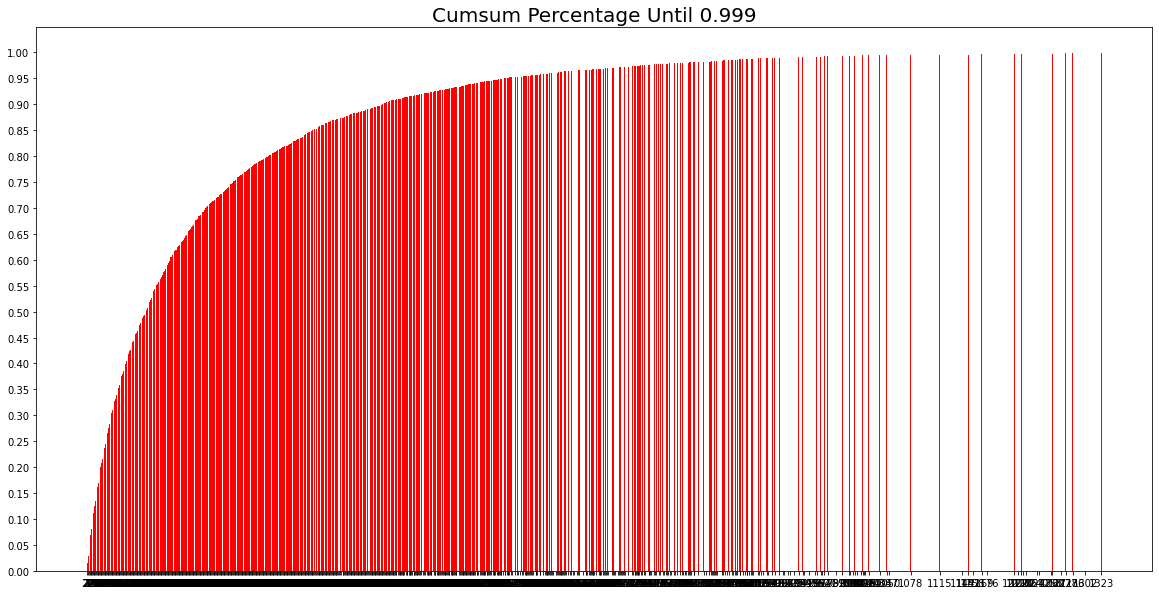

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [88]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [79]:
'''
month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data
'''

,UserId,ItemId,Rating,Time
28225,195,2808,3,2003-02-02 21:08:38
27759,195,1254,4,2003-02-06 17:23:42
27921,195,1456,2,2003-02-08 00:07:32
28443,195,468,3,2003-02-11 17:42:36
28255,195,2748,1,2003-02-11 18:23:28
...,...,...,...,...
984731,5950,3948,4,2003-02-27 18:13:57
984682,5950,3578,4,2003-02-27 18:14:30
984475,5950,3793,3,2003-02-27 18:15:10
984660,5950,3555,2,2003-02-27 18:15:37


최근의 데이터만을 사용해서 학습을 진행하기에는 너무 적은 데이터이기 때문에, 00년도부터 03년도까지의 모든 데이터를 사용합니다.

In [89]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있다.
# 이를 위해 반복문을 통해 지속적으로 제거 한다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_view) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_view)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len >= shortest].index
    data = data[data['UserId'].isin(user_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [90]:
user_len = data.groupby('UserId').size()
item_popular = data.groupby('ItemId').size()

print(user_len.mean())
print(item_popular.mean())

165.5975165562914
269.88909875876953


In [91]:
data = cleanse_recursive(data, shortest=3, least_view=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [92]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    user_last_time = data.groupby('UserId')['Time'].max().sort_values()
    user_in_train = data[data['Time'] < final_time - dt.timedelta(n_days)]
    user_in_test = data[data['Time'] >= final_time - dt.timedelta(n_days)]
    
    before_date = user_in_train
    after_date = user_in_test
    return before_date, after_date

In [93]:
tr, test = split_by_date(data, n_days=120)
tr, val = split_by_date(tr, n_days=120)

In [94]:
# data에 대한 정보를 살펴본다
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [95]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 986991
	 Users: 6039
	 Items: 3416
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-07-03 16:04:32

* valid Set Stats Info
	 Events: 6107
	 Users: 278
	 Items: 2078
	 First Time : 2002-07-03 17:31:04
	 Last Time : 2002-10-31 16:33:08

* test Set Stats Info
	 Events: 6513
	 Users: 277
	 Items: 2069
	 First Time : 2002-10-31 19:58:49
	 Last Time : 2003-02-28 17:49:50



In [96]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱한다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해준다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [97]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### 미니 배치 구성

In [98]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [99]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [100]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 986527, 986650, 986991], dtype=int32)

In [101]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6036, 6037, 6038])

In [102]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해야함
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져온다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해두자.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져온다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져온다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것이다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해준다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해준다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돈다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것이다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록한다..
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둔다.
        return start, end, mask, last_session, finished

In [103]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [104]:
iter_ex = iter(tr_data_loader)

In [105]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


### 모델 구성

In [106]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [107]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [108]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [113]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_users = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [110]:
# 테스트셋 성능 검증
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [111]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    520200    
_________________________________________________________________
dropout_1 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (128, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


### 모델 학습

In [112]:
# train 셋으로 학습하면서 valid 셋으로 검증한다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화한다. 아래 메서드에서 확인하자.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증한다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져온다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져온다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 한다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드다.
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)
        pred = model.predict(input_ohe, batch_size=args.batch_size)
#         pred_arg = tf.nn.top_k(pred, k=124, sorted=True)[1]  # softmax 값이 큰 순서대로 sorting 한다.
        pred_arg = tf.argsort(pred, direction='DESCENDING')
    
        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [114]:
# 학습
train_model(model, args)

Train:   0%|          | 0/7663 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.7]  

	 - Recall@20 epoch 1: 0.060547
	 - MRR@20    epoch 1: 0.013895



Train:   0%|          | 0/7663 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.4] 

	 - Recall@20 epoch 2: 0.085286
	 - MRR@20    epoch 2: 0.020270



Evaluation:  27%|██▋       | 12/45 [00:09<00:26,  1.26it/s]

	 - Recall@20 epoch 3: 0.089844
	 - MRR@20    epoch 3: 0.023082



### 모델 테스트

In [115]:
test_model(model, args, test)

Evaluation:  25%|██▌       | 12/48 [00:09<00:27,  1.31it/s]

	 - Recall@20: 0.150391
	 - MRR@20: 0.045170



### 모델 파라미터 변경


In [116]:
args_2 = Args(tr, val, test, batch_size=128, hsz=100, drop_rate=0.3, lr=0.01, epochs=5, k=20)
model_2 = create_model(args_2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 100), (128, 100)]  1055400   
_________________________________________________________________
dropout_2 (Dropout)          (128, 100)                0         
_________________________________________________________________
dense_2 (Dense)              (128, 3416)               345016    
Total params: 1,400,416
Trainable params: 1,400,416
Non-trainable params: 0
_________________________________________________________________


In [117]:
train_model(model_2, args_2)

Train:   0%|          | 0/7663 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.85] 

	 - Recall@20 epoch 1: 0.076823
	 - MRR@20    epoch 1: 0.019270



Train:   0%|          | 0/7663 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.8] 

	 - Recall@20 epoch 2: 0.086589
	 - MRR@20    epoch 2: 0.019761



Train:   0%|          | 0/7663 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.73] 

	 - Recall@20 epoch 3: 0.087891
	 - MRR@20    epoch 3: 0.022098



Train:   0%|          | 0/7663 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.7]  

	 - Recall@20 epoch 4: 0.083333
	 - MRR@20    epoch 4: 0.021446



Evaluation:  27%|██▋       | 12/45 [00:09<00:25,  1.27it/s]

	 - Recall@20 epoch 5: 0.092448
	 - MRR@20    epoch 5: 0.022326



In [125]:
test_model(model_2, args_2, test)

Evaluation:  25%|██▌       | 12/48 [00:09<00:27,  1.29it/s]

	 - Recall@20: 0.132161
	 - MRR@20: 0.038296



In [118]:
args_3 = Args(tr, val, test, batch_size=64, hsz=100, drop_rate=0.4, lr=0.001, epochs=10, k=25)
model_3 = create_model(args_3)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(64, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 100), (64, 100)]    1055400   
_________________________________________________________________
dropout_3 (Dropout)          (64, 100)                 0         
_________________________________________________________________
dense_3 (Dense)              (64, 3416)                345016    
Total params: 1,400,416
Trainable params: 1,400,416
Non-trainable params: 0
_________________________________________________________________


In [119]:
train_model(model_3, args_3)

Train:   0%|          | 0/15327 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.66]

	 - Recall@25 epoch 1: 0.116211
	 - MRR@25    epoch 1: 0.028288



Train:   0%|          | 0/15327 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.6] 

	 - Recall@25 epoch 2: 0.128255
	 - MRR@25    epoch 2: 0.033281



Train:   0%|          | 0/15327 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.49]

	 - Recall@25 epoch 3: 0.138997
	 - MRR@25    epoch 3: 0.034225



Train:   0%|          | 0/15327 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.54]

	 - Recall@25 epoch 4: 0.138997
	 - MRR@25    epoch 4: 0.034901



Train:   0%|          | 0/15327 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.38]

	 - Recall@25 epoch 5: 0.140299
	 - MRR@25    epoch 5: 0.036416



Train:   0%|          | 0/15327 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.43]

	 - Recall@25 epoch 6: 0.142578
	 - MRR@25    epoch 6: 0.036775



Train:   0%|          | 0/15327 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.21]

	 - Recall@25 epoch 7: 0.141602
	 - MRR@25    epoch 7: 0.036976



Train:   0%|          | 0/15327 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.41]

	 - Recall@25 epoch 8: 0.141602
	 - MRR@25    epoch 8: 0.036169



Train:   0%|          | 0/15327 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.37]

	 - Recall@25 epoch 9: 0.143555
	 - MRR@25    epoch 9: 0.037259



Evaluation:  53%|█████▎    | 48/91 [00:23<00:20,  2.06it/s]

	 - Recall@25 epoch 10: 0.145182
	 - MRR@25    epoch 10: 0.037535



In [120]:
test_model(model_3, args_3, test)

Evaluation:  48%|████▊     | 47/97 [00:18<00:20,  2.49it/s]

	 - Recall@25: 0.168218
	 - MRR@25: 0.058558



In [121]:
args_4 = Args(tr, val, test, batch_size=128, hsz=25, drop_rate=0.2, lr=0.05, epochs=5, k=15)
model_4 = create_model(args_4)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(128, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 25), (128, 25)]    258225    
_________________________________________________________________
dropout_4 (Dropout)          (128, 25)                 0         
_________________________________________________________________
dense_4 (Dense)              (128, 3416)               88816     
Total params: 347,041
Trainable params: 347,041
Non-trainable params: 0
_________________________________________________________________


In [123]:
train_model(model_4, args_4)

Train:   0%|          | 0/7663 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.64] 

	 - Recall@15 epoch 1: 0.030599
	 - MRR@15    epoch 1: 0.006024



Train:   0%|          | 0/7663 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.57] 

	 - Recall@15 epoch 2: 0.037109
	 - MRR@15    epoch 2: 0.009616



Train:   0%|          | 0/7663 [00:00<?, ?it/s, accuracy=0.00781, train_loss=6.48]

	 - Recall@15 epoch 3: 0.038411
	 - MRR@15    epoch 3: 0.011185



Train:   0%|          | 0/7663 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.59] 

	 - Recall@15 epoch 4: 0.033203
	 - MRR@15    epoch 4: 0.008543



Evaluation:  27%|██▋       | 12/45 [00:07<00:21,  1.54it/s]

	 - Recall@15 epoch 5: 0.042318
	 - MRR@15    epoch 5: 0.010008



In [124]:
test_model(model_4, args_4, test)

Evaluation:  25%|██▌       | 12/48 [00:09<00:29,  1.24it/s]

	 - Recall@15: 0.070964
	 - MRR@15: 0.018200



# result
- model
	 - Recall@20: 0.150391
	 - MRR@20: 0.045170


- model_2
	 - Recall@20: 0.132161
	 - MRR@20: 0.038296
    
    
- model_3
	 - Recall@25: 0.168218
	 - MRR@25: 0.058558
     
     
- model_4
	 - Recall@15: 0.070964
	 - MRR@15: 0.018200

# 회고

https://github.com/ASNKMGSK/AI-Study-and-Mini-Projects/blob/7c6be40d3359da5f99f2ec1e16c450aea18e6d2f/Week10/%5BE-17%5D%20Movie%20Prediction.ipynb 의 코드를 참고해서 프로젝트를 진행했습니다.

위 결과를 보면, 모델3번의 성능이 4개의 모델중 가장 좋았습니다. 아무래도 epoch의 수가 다른 모델의 2배정도 되니까 당연한 결과인거 같기는 합니다. epoch의 수가 같은 모델 2번과 4번중 모델 2번의 성능이 좋았는데, 이는 drop_rate이 높아서 모델의 최적화가 비교적 잘되어서 그런거 같습니다. 모델의 하이퍼 파라미터의 조정 뿐만아니라 모델의 구성도 달리해서 다양한 구성으로 실험을 진행해 보고 싶었는데, 무엇을 넣어야 되고 무엇을 빼야하는지에 관해 아직 기본이 안잡혀 있어서 나중에 노드 복습할때 개인적으로 모델의 구성을 달리해서 실험을 해보고 싶다는 생각이 들었습니다.